## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles

## Imports

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [7]:
import pandas as pd
import io
from google.colab import files

In [8]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [9]:
train = pd.read_csv('/content/gdrive/MyDrive/Liar Dataset/fake news detection(LIAR)/liar_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Liar Dataset/fake news detection(LIAR)/liar_test.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


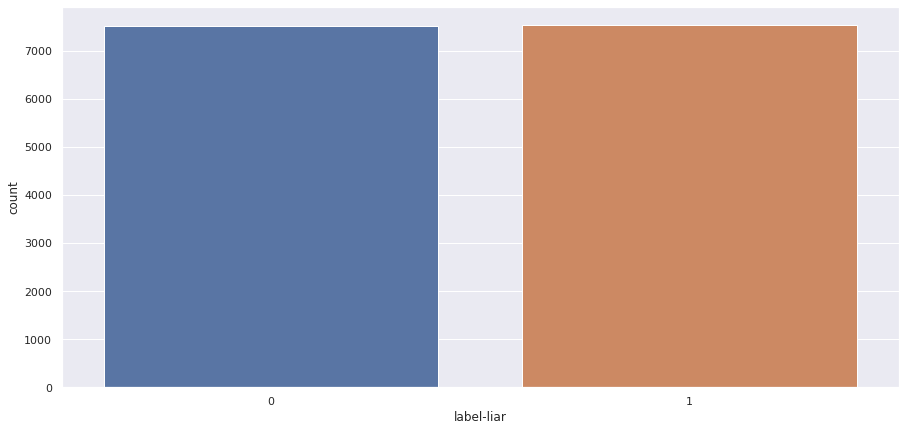

In [27]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(train['label-liar'])

In [12]:
train = train.replace(to_replace ="barely-true",
                 value =1)
train = train.replace(to_replace ="pants-fire",
                 value =1)
train = train.replace(to_replace ="half-true",
                 value =0)
train = train.replace(to_replace ="mostly-true",
                 value =0)
train = train.replace(to_replace ="false",
                 value =1)
train = train.replace(to_replace ="true",
                 value =0)

In [13]:
test = test.replace(to_replace ="barely-true",
                 value =1)
test= test.replace(to_replace ="pants-fire",
                 value =1)
test = test.replace(to_replace ="half-true",
                 value =1)
test = test.replace(to_replace ="mostly-true",
                 value =1)
test = test.replace(to_replace ="false",
                 value =1)
test = test.replace(to_replace ="true",
                 value =0)

In [14]:
train = train.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)
test = test.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)


In [15]:
train.head(10)

statement  ... label-liar
0         "COVID-19 started because we eat animals."  ...          1
1  Says Michelle Obama has 43 people on her staff...  ...          1
2  Says President Donald Trump "has signed more l...  ...          0
3  "US representatives promise implement of UN gu...  ...          1
4  "The federal government borrows $4 billion eve...  ...          0
5  "U.S. teenagers have now fallen behind their c...  ...          0
6  Says a drug test can be performed for "just $4...  ...          0
7  "The United States is the ONLY industrialized ...  ...          0
8  "Hillary's main extracurricular activity in la...  ...          1
9    Says Ohio Gov. John Kasich is "very unpopular."  ...          1

[10 rows x 3 columns]

In [ ]:
train.fullText_based_content[7]

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [16]:
# Merging title and text
train['fullText_based_content'] = train['statement'] + ' ' + train['fullText_based_content']
test['fullText_based_content'] = test['statement'] + ' ' + test['fullText_based_content']


# We can merge both together since we now have labels
final_data = pd.concat([train, test])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['statement'], axis = 1)
final_data = final_data.sample(frac=1)
final_data.head(10)

fullText_based_content  label-liar
12278  Says that when President Bill Clinton raised t...           0
11178  Russia has "tremendous numbers of nuclear warh...           0
671    "The national debt is on track to double durin...           0
13780  "Gov. Scott Walker and the Republican-controll...           1
12446  Schuyler VanValkenburg co-sponsored a bill tha...           1
9914   We have cut "our deficits by almost three-quar...           0
1181   $50,000. That's what every child owes today be...           0
9406   Says paid family leave is "a program that is s...           0
12371  Odds of winning the Monopoly Millionaire insta...           0
2608   Says Donald Trump’s plan to repeal the estate ...           0

In [18]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['fullText_based_content'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['label-liar'])

## Word2Vec

In [19]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [20]:
model.wv.most_similar("corona")

[('infected', 0.8474705815315247),
 ('bats', 0.8440048694610596),
 ('fever', 0.8426977396011353),
 ('stomach', 0.8355704545974731),
 ('cough', 0.8293744325637817),
 ('swine', 0.8260664939880371),
 ('influenza', 0.8223215341567993),
 ('droplets', 0.8182244896888733),
 ('sars', 0.8180039525032043),
 ('“corona', 0.8147619962692261)]

## Sentence Vectors

In [21]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
X_np = np.array(X)
X_np.shape

(16318, 100)

## Clustering

In [31]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 120510.90361733986
start iteration
done sorting
end inner loop
Iteration 1, inertia 112108.28079628492
start iteration
done sorting
end inner loop
Iteration 2, inertia 110683.7120291764
start iteration
done sorting
end inner loop
Iteration 3, inertia 110317.73864712875
start iteration
done sorting
end inner loop
Iteration 4, inertia 110216.00191180901
start iteration
done sorting
end inner loop
Iteration 5, inertia 110184.94513955402
start iteration
done sorting
end inner loop
Iteration 6, inertia 110174.78098503986
start iteration
done sorting
end inner loop
Iteration 7, inertia 110171.5802060588
start iteration
done sorting
end inner loop
Iteration 8, inertia 110170.81641582967
start iteration
done sorting
end inner loop
Iteration 9, inertia 110170.72707230938
center shift 4.201330e-06 within tolerance 7.996511e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, i

In [32]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

Sentence  Labels  Prediction
0  [says, president, clinton, raised, tax, rates,...       0           0
1  [russia, tremendous, numbers, nuclear, warhead...       0           1
2  [national, debt, track, double, obama’s, presi...       0           0
3  [gov, scott, walker, republican, controlled, s...       1           0
4  [schuyler, vanvalkenburg, sponsored, allowed, ...       1           1
5  [cut, deficits, quarters, cut, deficits, quart...       0           0
6  [child, owes, today, washington, politicians, ...       0           0
7  [says, paid, family, leave, program, standard,...       0           0
8  [odds, winning, monopoly, millionaire, instant...       0           1
9  [says, donald, trump’s, plan, repeal, estate, ...       0           0

The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [33]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 58.18727785267802%


## Visualization

In [34]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [35]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

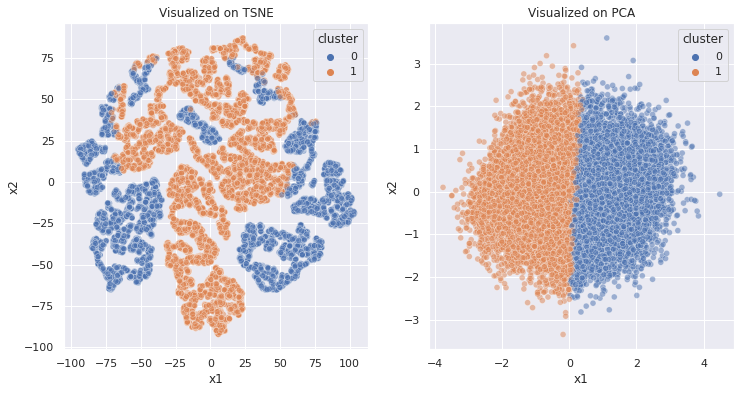

In [36]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [41]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "On Thursday in the Afternoon, William Anderton , Printer , was brought to the Bar, and an Indictment of High-Treason was read against him; for that he did Compose, Print and publish Two Malicious, Scandalous and Traitorous Libels, The first Entitled, Remarks upon the present Confederacy, and late Revolution in England. The second Entitled, A French Conquest neither desirable, nor practicable."

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)

In [38]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)